In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [90]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [91]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [92]:
# 加载MNIST数据集
batch_size = 512
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_data = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [93]:
class NetV1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10,20,3)
        self.fc1 = nn.Linear(20*10*10,500)
        self.fc2 = nn.Linear(500,10)
    
    def forward(self,x):  
        input_size = x.size(0) #batch_size 
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        
        x = x.view(input_size,-1) #全连接
        x = self.fc1(x)
        x = nn.functional.relu(x) 
        x = self.fc2(x)
        output = nn.functional.log_softmax(x,dim=1)
        return x

In [94]:
class NetV0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        output = nn.functional.log_softmax(x,dim=1)
        return x
    

In [95]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## 训练模型
我们使用训练数据来训练模型，并在训练过程中打印损失值。

In [96]:
model = NetV1().to(device)
optimizer = optim.Adam(model.parameters())

In [97]:
#定义训练函数模型
def train_model(model,device,train_loader,optimizers,epoch):
    model.train()
    for batch_index,(data,target) in enumerate(train_loader):
        data,target = data.to(device),target.to(device) # [512, 1, 28, 28]

        optimizer.zero_grad()
        output = model(data)

        loss = nn.functional.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
        
        if batch_index%3000 == 0:
            print("Train Epoch :{}  Loss:{:.6f}".format(epoch,loss.item()))

In [98]:
EPOCH=10
for epoch in range(1,EPOCH+1):
    train_model(model,device,train_data,optimizer,epoch)


Train Epoch :1  Loss:2.319835
Train Epoch :2  Loss:0.107440
Train Epoch :3  Loss:0.038028
Train Epoch :4  Loss:0.033185
Train Epoch :5  Loss:0.042697
Train Epoch :6  Loss:0.025743
Train Epoch :7  Loss:0.030956
Train Epoch :8  Loss:0.013553
Train Epoch :9  Loss:0.019363
Train Epoch :10  Loss:0.004308


In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt

def test_model(model,device,train_loader,optimizers,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = torch.tensor([])
    all_targets = torch.tensor([])
    with torch.no_grad():
        for data,target in test_data:
            data,target = data.to(device),target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output,target,reduction='sum').item()
            pred = output.max(1,keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds = torch.cat((all_preds, pred.cpu()), dim=0)
            all_targets = torch.cat((all_targets, target.cpu()), dim=0)

    # loss 和 accuracy            
    test_loss /= len(test_data.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
        test_loss, correct, len(test_data.dataset), 100. * correct / len(test_data.dataset)
    ))

    # 混淆矩阵
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)



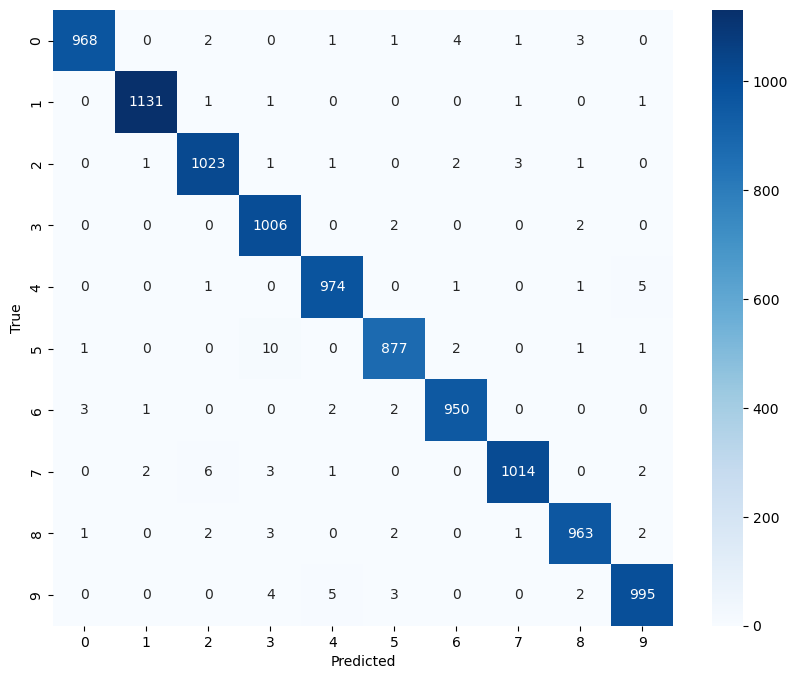

In [100]:
test_model(model,device,test_data,optimizer,1)

In [102]:
# 保存模型
torch.save(model.state_dict(), 'mnist_model')